In [54]:
from scipy.io import loadmat

# Load the .MAT file
data = loadmat('/kaggle/input/whu-hyperspectral-dataset/WHU-Hi-LongKou/WHU_Hi_LongKou.mat')
labels =loadmat('/kaggle/input/whu-hyperspectral-dataset/WHU-Hi-LongKou/WHU_Hi_LongKou_gt.mat')

# Print available keys/variables in the dataset
print(data.keys())
print(labels.keys())

dict_keys(['__header__', '__version__', '__globals__', 'WHU_Hi_LongKou'])
dict_keys(['__header__', '__version__', '__globals__', 'WHU_Hi_LongKou_gt'])


In [55]:
# Access the content of 'WHU_Hi_LongKou'
longkou_data = data['WHU_Hi_LongKou']

# Check the type and structure
print(type(longkou_data))
print(longkou_data.dtype)  # If it's a NumPy array, this will provide more details
print(longkou_data.shape)  # If it's a NumPy array, check its dimensions

# If it looks like a structured array or dictionary, print keys or field names
if isinstance(longkou_data, np.ndarray):
    print(longkou_data)


<class 'numpy.ndarray'>
float32
(550, 400, 270)
[[[ 0.11914432  0.4523278   0.5890478  ...  8.633758    8.413543
    8.8901205 ]
  [ 0.26605487  0.43666995  0.68460506 ...  8.744693    8.196497
    8.692479  ]
  [ 0.13548897  0.5527791   0.56557286 ...  8.821       8.447286
    8.567034  ]
  ...
  [ 0.18725206  0.41301754  0.6007176  ... 12.695165   13.026531
   13.208923  ]
  [ 0.19299987  0.50547904  0.72392505 ... 12.857188   12.940057
   12.857613  ]
  [ 0.20652154  0.5545493   0.68340653 ... 12.434352   12.8901825
   12.42505   ]]

 [[ 0.18990183  0.44629064  0.6315769  ...  9.140132    8.747664
    8.734673  ]
  [ 0.15167215  0.40927827  0.6479068  ...  8.590359    8.53363
    9.2480955 ]
  [ 0.16756018  0.5589234   0.6003149  ...  8.631819    8.573527
    9.016789  ]
  ...
  [ 0.19278923  0.35343558  0.97300845 ... 13.069389   13.403014
   13.53222   ]
  [ 0.14915654  0.50214165  0.7291968  ... 13.281838   12.9276705
   13.487201  ]
  [ 0.14915654  0.50214165  0.7291968  ... 13.

In [56]:
ground_truth = labels['WHU_Hi_LongKou_gt']
print(type(ground_truth))
print(ground_truth.shape)  # Check its dimensions
print(np.unique(ground_truth))  # Check unique values (classes)


<class 'numpy.ndarray'>
(550, 400)
[0 1 2 3 4 5 6 7 8 9]


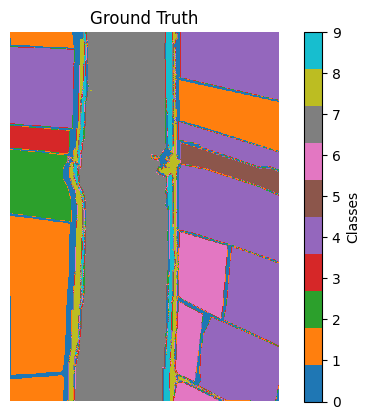

In [57]:
import matplotlib.pyplot as plt

plt.imshow(ground_truth, cmap='tab10')  # Use 'tab10' for categorical labels
plt.title("Ground Truth")
plt.colorbar(label="Classes")
plt.axis("off")
plt.show()

In [58]:
# Normalize data for each band to [0, 1]
image_normalized = (longkou_data - np.min(longkou_data)) / (np.max(longkou_data) - np.min(longkou_data))


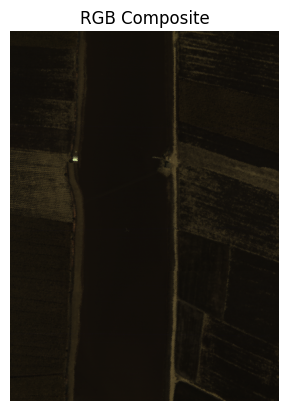

In [59]:
import matplotlib.pyplot as plt

# Select three bands for RGB visualization
red_band = image_normalized[:, :, 50]
green_band = image_normalized[:, :, 30]
blue_band = image_normalized[:, :, 10]

# Stack into an RGB image
rgb_image = np.dstack((red_band, green_band, blue_band))

# Plot the RGB image
plt.imshow(rgb_image)
plt.title("RGB Composite")
plt.axis("off")
plt.show()


In [12]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
import random
import scipy.ndimage
from tensorflow.keras import utils as np_utils
import scipy
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from keras import backend as K

In [13]:
!pip install spectral
import spectral

In [14]:
#import tensorflow_probability as tfp
import warnings
warnings.filterwarnings("ignore")
K.set_image_data_format('channels_last')

In [53]:
def load_data():
    data = sio.loadmat('/kaggle/input/whu-hyperspectral-dataset/WHU-Hi-LongKou/WHU_Hi_LongKou.mat')['WHU_Hi_LongKou']
    labels = sio.loadmat('/kaggle/input/whu-hyperspectral-dataset/WHU-Hi-LongKou/WHU_Hi_LongKou_gt.mat')['WHU_Hi_LongKou_gt']
    return data, labels



In [16]:
def splitTrainTestSet(X, y, testRatio=0.25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345, stratify=y)
    return X_train, X_test, y_train, y_test

In [17]:
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts
    newX = X[y == uniqueLabels[0], :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :]
    newY = newY[rand_perm]
    return newX, newY

In [18]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [19]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [20]:
def createPatches(X, y, windowSize=1, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [21]:
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            flipped_patch = np.flipud(patch)
        if (num == 1):
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    return X_train

In [22]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# datagen.fit(X_train)
# model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=10, verbose=1)


In [23]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [24]:
numComponents = 30
windowSize = 1
testRatio = 0.25
PATCH_SIZE = 1
X, y = load_data()
uniqueLabels, labelCounts = np.unique(y, return_counts=True)
print(labelCounts)
print(uniqueLabels)

[15458 34511  8374  3031 63212  4151 11854 67056  7124  5229]
[0 1 2 3 4 5 6 7 8 9]


In [25]:
X,pca = applyPCA(X,numComponents=numComponents)
XPatches, yPatches = createPatches(X, y, windowSize= 1)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
X_train = AugmentData(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[3])
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [26]:
model = Sequential()
model.add(Conv1D(filters=20, kernel_size=3, activation='relu', input_shape = (30,1), padding ='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [27]:
# sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# model.summary()

In [28]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.001)  # Use default learning rate
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [29]:

print(X_train.shape, y_train.shape)  # Training set
print(X_test.shape, y_test.shape)    # Testing set


(451942, 30, 1) (451942, 9)
(51136, 30, 1) (51136, 9)


Epoch 1/10


I0000 00:00:1732176281.224053     111 service.cc:145] XLA service 0x7a675c003780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732176281.224112     111 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 105/7062 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.4680 - loss: 1.6617 

I0000 00:00:1732176282.925819     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7062/7062 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9434 - loss: 0.1946 - val_accuracy: 0.9882 - val_loss: 0.0367
Epoch 2/10
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9911 - loss: 0.0297 - val_accuracy: 0.9816 - val_loss: 0.0601
Epoch 3/10
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9943 - loss: 0.0189 - val_accuracy: 0.9907 - val_loss: 0.0337
Epoch 4/10
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9961 - loss: 0.0125 - val_accuracy: 0.9894 - val_loss: 0.0404
Epoch 5/10
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9968 - loss: 0.0105 - val_accuracy: 0.9923 - val_loss: 0.0296
Epoch 6/10
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9973 - loss: 0.0089 - val_accuracy: 0.9932 - val_loss: 0.0308
Epoch 7/10
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9977 - loss: 0.0076 - val_accuracy: 0.9914 - val_loss: 0.0379
Epoch 8/10
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9983 - loss: 0.0060 - val

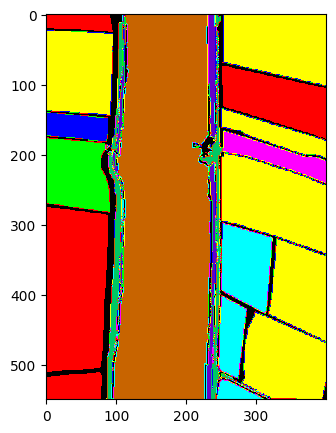

In [36]:
from keras.callbacks import History
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = History()
history = model.fit(
    X_train, y_train,
  #  validation_split=0.2,  # Reserve 20% of training data for validation
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, history]  # Corrected this line
)

# Assuming 'y' is the ground truth data you want to visualize
ground_truth = spectral.imshow(classes=y, figsize=(5, 5))


from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,  # Higher epoch count, but early stopping will terminate early
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=15,
    verbose=1,
    validation_data=(X_test, y_test)
)
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

model.fit(X_train, y_train, batch_size=64, epochs=15, verbose=1)
ground_truth = spectral.imshow(classes = y,figsize =(5,5))


In [37]:
# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

Test Accuracy: 99.23%


In [38]:
height = y.shape[0]
width = y.shape[1]
print(height,width)

550 400


In [39]:
patches = []
positions = []
outputs = np.zeros((height,width))

In [40]:
for i in range(height):
    for j in range(width):
        target = int(y[int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            patches.append(image_patch.reshape(1, image_patch.shape[2], image_patch.shape[0]).astype('float32'))
            positions.append((int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)))


In [41]:
patches = np.concatenate(patches, axis=0)
predictions = model.predict(patches)
for prediction, position in zip(predictions, positions):
    outputs[position[0]][position[1]] = np.argmax(prediction) + 1


6392/6392 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


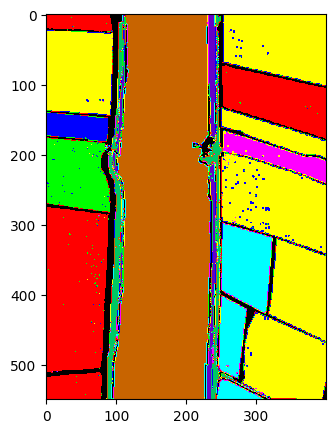

In [42]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

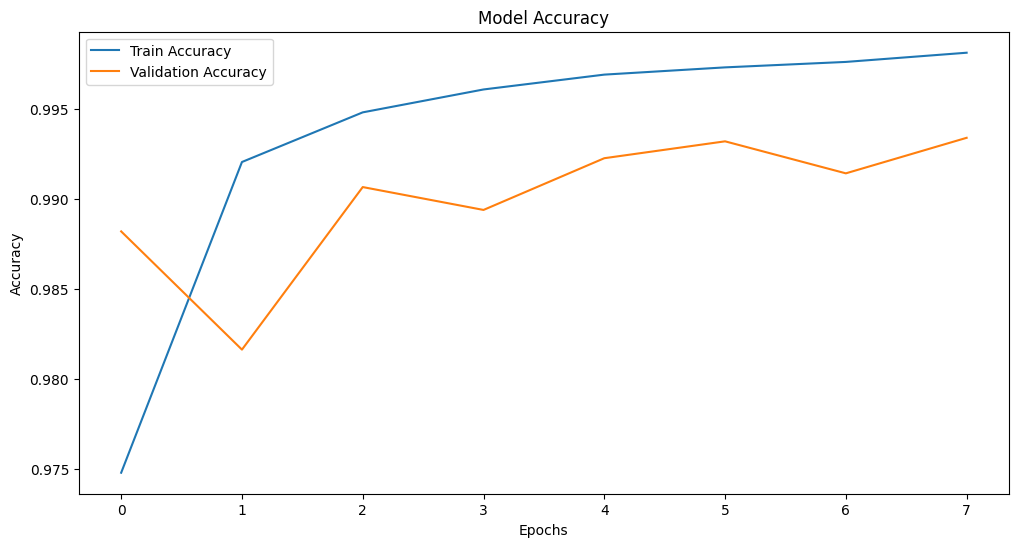

In [43]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


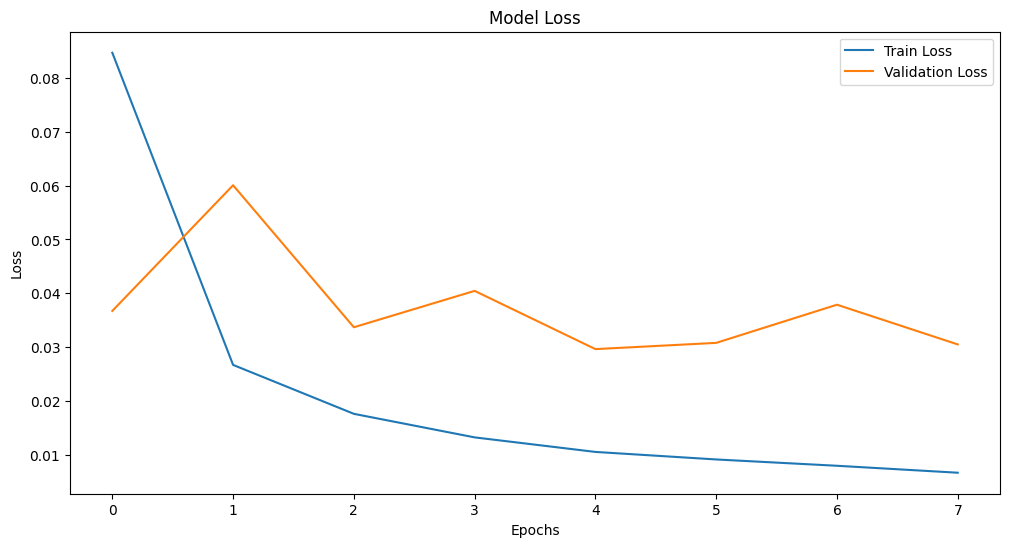

In [44]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))

1598/1598 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8628
           1       0.98      0.96      0.97      2093
           2       0.97      0.99      0.98       758
           3       0.99      0.99      0.99     15803
           4       0.91      0.99      0.95      1038
           5       1.00      1.00      1.00      2964
           6       1.00      1.00      1.00     16764
           7       0.98      0.98      0.98      1781
           8       0.97      0.99      0.98      1307

    accuracy                           0.99     51136
   macro avg       0.98      0.99      0.98     51136
weighted avg       0.99      0.99      0.99     51136



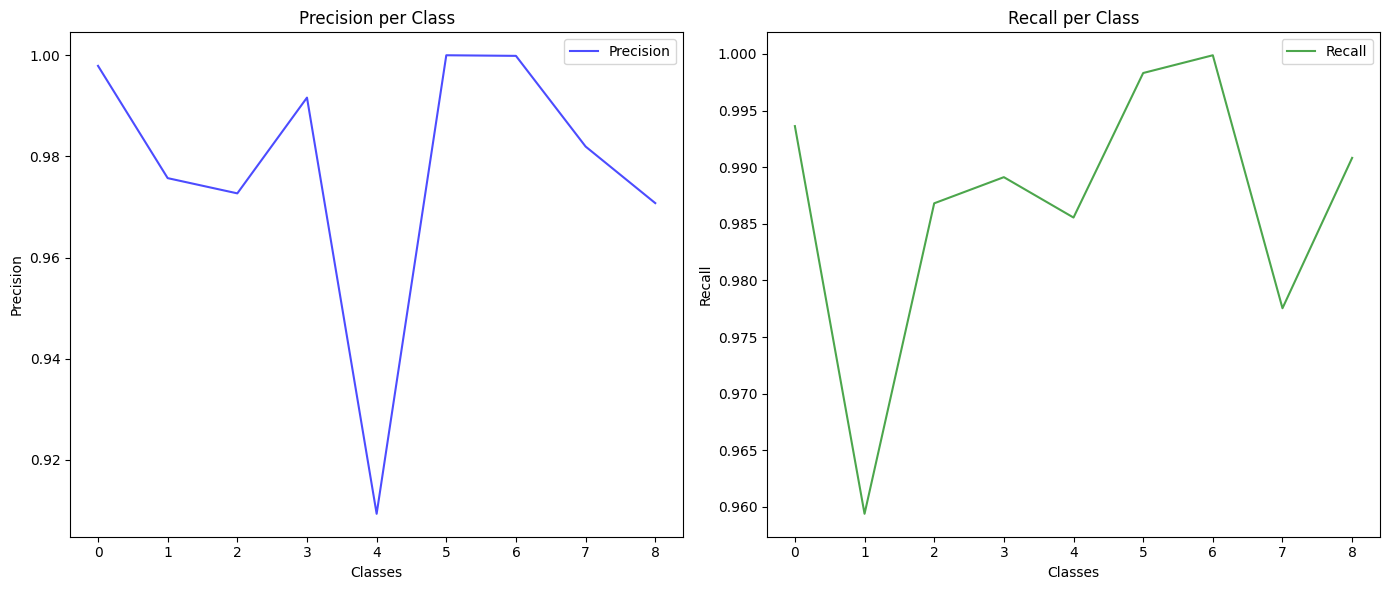

In [48]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_classes are already defined
precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average=None)

# Create two subplots for precision and recall
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Precision
axs[0].plot(range(len(precision)), precision, label='Precision', alpha=0.7, color='blue')
axs[0].set_title('Precision per Class')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Precision')
axs[0].legend()

# Plot Recall
axs[1].plot(range(len(recall)), recall, label='Recall', alpha=0.7, color='green')
axs[1].set_title('Recall per Class')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Recall')
axs[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


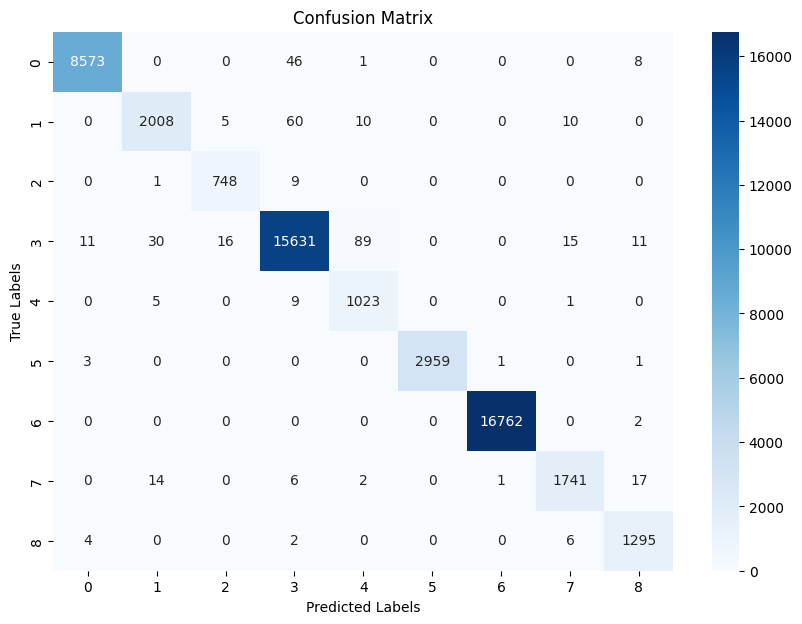

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_classes are already defined
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [61]:
import numpy as np

# Get unique labels from the ground truth
unique_labels = np.unique(ground_truth)
print("Unique class labels in the dataset:", unique_labels)


Unique class labels in the dataset: [0 1 2 3 4 5 6 7 8 9]


In [62]:
if 'class_names' in data.keys():  # Check if class names exist in the .mat file
    class_names = data['class_names']
    for label, name in enumerate(class_names, start=1):  # Assuming 1-based indexing
        print(f"Class {label}: {name}")


In [63]:
import matplotlib.pyplot as plt
from matplotlib import colors

# Define a colormap
cmap = plt.cm.get_cmap('tab10', len(unique_labels))  # Tab10 colormap

# Create a dictionary of label to color
label_to_color = {label: cmap(idx) for idx, label in enumerate(unique_labels)}

# Display the mapping
for label, color in label_to_color.items():
    print(f"Class {label}: Color {color}")


Class 0: Color (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
Class 1: Color (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
Class 2: Color (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
Class 3: Color (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
Class 4: Color (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)
Class 5: Color (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)
Class 6: Color (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)
Class 7: Color (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0)
Class 8: Color (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)
Class 9: Color (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)


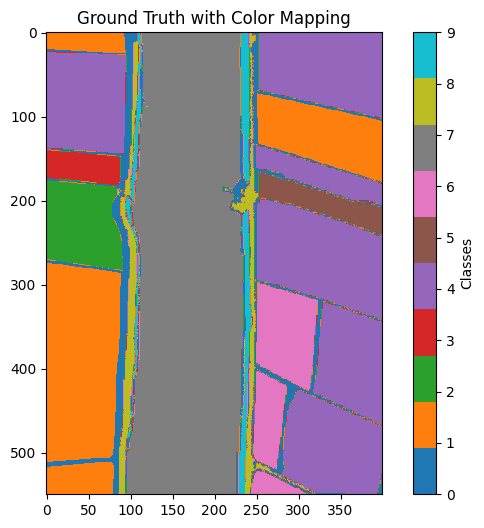

In [64]:
# Display the ground truth with a color map
plt.figure(figsize=(8, 6))
plt.imshow(ground_truth, cmap='tab10')  # Use a discrete colormap
plt.title("Ground Truth with Color Mapping")
plt.colorbar(ticks=unique_labels, label="Classes")
plt.show()


In [70]:
# Replace these names with actual class descriptions from the dataset
class_names = {
    0: "Background",
    1: "Corn",
    2: "Cotton",
    3: "Sesame",
    4: "Broad Leaf Soyabean",
    5: "Narrow Leaf Soyabean",
    6: "Rice",
    7: "Water Body",
    8: "Mixed Weed",
    9: "Roads & Houses"
}

for label, color in label_to_color.items():
    print(f"{class_names.get(label, 'Unknown Class')} (Class {label}): Color {color}")


Background (Class 0): Color (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
Corn (Class 1): Color (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
Cotton (Class 2): Color (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
Sesame (Class 3): Color (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
Broad Leaf Soyabean (Class 4): Color (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)
Narrow Leaf Soyabean (Class 5): Color (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)
Rice (Class 6): Color (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)
Water Body (Class 7): Color (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0)
Mixed Weed (Class 8): Color (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)
Roads & Houses (Class 9): Color (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)


<Figure size 500x500 with 0 Axes>

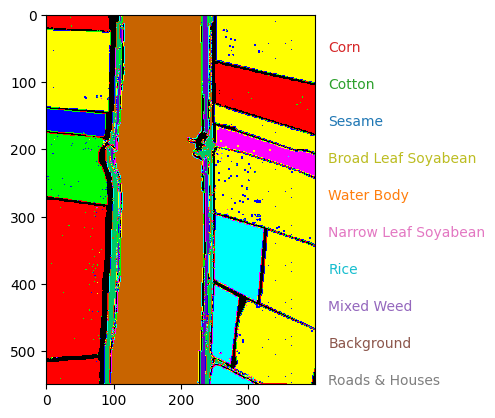

In [78]:
import matplotlib.pyplot as plt
import spectral

# Assuming 'outputs' contains the predicted class labels and 'class_mapping' and 'colors' are defined as you previously shared

# Show the image with 'spectral.imshow'
plt.figure(figsize=(5, 5))
predict_image = spectral.imshow(classes=outputs.astype(int))

# Add class names and corresponding colors beside the image
class_mapping = {
    0: "Corn",
    1: "Cotton",
    2: "Sesame",
    3: "Broad Leaf Soyabean",
    4: "Water Body",
    5: "Narrow Leaf Soyabean",
    6: "Rice",
    7: "Mixed Weed",
    8: "Background",
    9: "Roads & Houses",
}

colors = [
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),  
    (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
    (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),              
    (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
    (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), 
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),    
    (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),   
]

# Positioning the text for class names and colors beside the image
for i, class_id in class_mapping.items():
    color = colors[i]
    plt.text(1.05, 0.9 - i * 0.1, f'{class_id}', color=color, fontsize=10, transform=plt.gca().transAxes)

# Show the plot with the class names and colors
plt.show()
